In [8]:
# ✅ run_nb_dt_simple.py

import os
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from scipy.sparse import hstack

# -------------------------------
# ⚙️ Config
# -------------------------------
nb_alphas = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
tree_depths = [5, 10, 15, 20, 30, 50]
tree_splits = [2, 5, 10, 20]
tree_criteria = ["gini", "entropy"]

# -------------------------------
# 📁 Setup
# -------------------------------
os.makedirs("models/results/classical_models_tuned", exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
def load_data():
    train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
    test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])
    return {
        "X_train": train_df["clean_headline"].astype(str).reset_index(drop=True),
        "y_train": train_df["label_encoded"].reset_index(drop=True),
        "X_test": test_df["clean_headline"].astype(str).reset_index(drop=True),
        "y_test": test_df["label_encoded"].reset_index(drop=True),
    }

# -------------------------------
# 🔠 Vectorizers
# -------------------------------
def get_vectorized_data(vec_name, data):
    if vec_name == "TF-IDF BiChar":
        vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
        vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
        X_train_vec = hstack([vec1.fit_transform(data["X_train"]), vec2.fit_transform(data["X_train"])]).tocsr()
        X_test_vec = hstack([vec1.transform(data["X_test"]), vec2.transform(data["X_test"])]).tocsr()
    else:
        vectorizer = {
            "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2), min_df=2),
            "Char TF-IDF": TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2),
        }[vec_name]
        X_train_vec = vectorizer.fit_transform(data["X_train"]).tocsr()
        X_test_vec = vectorizer.transform(data["X_test"]).tocsr()

    print(f"✅ Vectorizer: {vec_name} → Shape: {X_train_vec.shape}, Mem: {X_train_vec.data.nbytes / (1024*1024):.2f} MB")
    return X_train_vec, X_test_vec

In [1]:
# ✅ run_nb_dt_simple.py

import os
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from scipy.sparse import hstack

# -------------------------------
# ⚙️ Config
# -------------------------------
nb_alphas = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
tree_depths = [5, 10, 15, 20, 30, 50]
tree_splits = [2, 5, 10, 20]
tree_criteria = ["gini", "entropy"]

# -------------------------------
# 📁 Setup
# -------------------------------
os.makedirs("models/results/classical_models_tuned", exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
def load_data():
    train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
    test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])
    return {
        "X_train": train_df["clean_headline"].astype(str).reset_index(drop=True),
        "y_train": train_df["label_encoded"].reset_index(drop=True),
        "X_test": test_df["clean_headline"].astype(str).reset_index(drop=True),
        "y_test": test_df["label_encoded"].reset_index(drop=True),
    }

# -------------------------------
# 🔠 Vectorizers
# -------------------------------
def get_vectorized_data(vec_name, data):
    if vec_name == "TF-IDF BiChar":
        vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
        vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
        X_train_vec = hstack([vec1.fit_transform(data["X_train"]), vec2.fit_transform(data["X_train"])]).tocsr()
        X_test_vec = hstack([vec1.transform(data["X_test"]), vec2.transform(data["X_test"])]).tocsr()
    else:
        vectorizer = {
            "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2), min_df=2),
            "Char TF-IDF": TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2),
        }[vec_name]
        X_train_vec = vectorizer.fit_transform(data["X_train"]).tocsr()
        X_test_vec = vectorizer.transform(data["X_test"]).tocsr()

    print(f"✅ Vectorizer: {vec_name} → Shape: {X_train_vec.shape}, Mem: {X_train_vec.data.nbytes / (1024*1024):.2f} MB")
    return X_train_vec, X_test_vec

# -------------------------------
# 📌 Naive Bayes
# -------------------------------
def run_nb(X_train_vec, X_test_vec, y_train, y_test, vec_name):
    results = []
    for alpha in nb_alphas:
        print(f"🔧 NB alpha={alpha}")
        model = MultinomialNB(alpha=alpha)
        model.fit(X_train_vec, y_train)
        preds = model.predict(X_test_vec)
        probas = model.predict_proba(X_test_vec)[:, 1]
        f1 = f1_score(y_test, preds)
        auc = roc_auc_score(y_test, probas)
        report = classification_report(y_test, preds, output_dict=True)
        fname = f"models/results/classical_models_tuned/nb_{vec_name.replace(' ', '_')}_alpha{alpha}.csv"
        pd.DataFrame(report).transpose().to_csv(fname)
        results.append({
            "Model": "NaiveBayes", "Vec": vec_name,
            "alpha": alpha, "F1": f1, "AUC": auc
        })
    return results

# -------------------------------
# 🌳 Decision Tree
# -------------------------------
def run_dt(X_train_vec, X_test_vec, y_train, y_test, vec_name):
    results = []
    for d in tree_depths:
        for s in tree_splits:
            for crit in tree_criteria:
                print(f"🌳 DT depth={d} split={s} crit={crit}")
                model = DecisionTreeClassifier(max_depth=d, min_samples_split=s, criterion=crit, random_state=42)
                model.fit(X_train_vec, y_train)
                preds = model.predict(X_test_vec)
                f1 = f1_score(y_test, preds)
                auc = roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1])
                report = classification_report(y_test, preds, output_dict=True)
                fname = f"models/results/classical_models_tuned/dt_{vec_name.replace(' ', '_')}_d{d}_s{s}_{crit}.csv"
                pd.DataFrame(report).transpose().to_csv(fname)
                results.append({
                    "Model": "DecisionTree", "Vec": vec_name,
                    "Depth": d, "Split": s, "Criterion": crit,
                    "F1": f1, "AUC": auc
                })
    return results

# -------------------------------
# 🚀 Run All
# -------------------------------
data = load_data()
vectorizers = ["TF-IDF Bigrams", "Char TF-IDF", "TF-IDF BiChar"]
all_results = []

for vec_name in vectorizers:
    print(f"\n🔍 Running for vectorizer: {vec_name}")
    try:
        X_train_vec, X_test_vec = get_vectorized_data(vec_name, data)
    except Exception as e:
        print(f"❌ Skipping {vec_name}: {e}")
        continue

    all_results += run_nb(X_train_vec, X_test_vec, data["y_train"], data["y_test"], vec_name)
    all_results += run_dt(X_train_vec, X_test_vec, data["y_train"], data["y_test"], vec_name)

# ✅ Save results
summary = pd.DataFrame(all_results)
summary.to_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv", index=False)
print("\n✅ Summary saved to research_nb_dt_summary.csv")


🔍 Running for vectorizer: TF-IDF Bigrams
✅ Vectorizer: TF-IDF Bigrams → Shape: (43157, 42003), Mem: 3.01 MB
🔧 NB alpha=0.001
🔧 NB alpha=0.01
🔧 NB alpha=0.1
🔧 NB alpha=0.5
🔧 NB alpha=1.0
🔧 NB alpha=5.0
🔧 NB alpha=10.0
🌳 DT depth=5 split=2 crit=gini
🌳 DT depth=5 split=2 crit=entropy
🌳 DT depth=5 split=5 crit=gini
🌳 DT depth=5 split=5 crit=entropy
🌳 DT depth=5 split=10 crit=gini
🌳 DT depth=5 split=10 crit=entropy
🌳 DT depth=5 split=20 crit=gini
🌳 DT depth=5 split=20 crit=entropy
🌳 DT depth=10 split=2 crit=gini
🌳 DT depth=10 split=2 crit=entropy
🌳 DT depth=10 split=5 crit=gini
🌳 DT depth=10 split=5 crit=entropy
🌳 DT depth=10 split=10 crit=gini
🌳 DT depth=10 split=10 crit=entropy
🌳 DT depth=10 split=20 crit=gini
🌳 DT depth=10 split=20 crit=entropy
🌳 DT depth=15 split=2 crit=gini
🌳 DT depth=15 split=2 crit=entropy
🌳 DT depth=15 split=5 crit=gini
🌳 DT depth=15 split=5 crit=entropy
🌳 DT depth=15 split=10 crit=gini
🌳 DT depth=15 split=10 crit=entropy
🌳 DT depth=15 split=20 crit=gini
🌳 DT depth

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False  # if you face minus sign issues
plt.rcParams['font.family'] = 'DejaVu Sans'  # explicitly set a safe font

def plot_best_per_model(csv_path):
    df = pd.read_csv(csv_path)
    best_df = df.sort_values(by="F1", ascending=False).groupby("Model").first().reset_index()

    plt.figure(figsize=(10, 5))
    bars = plt.bar(best_df["Model"], best_df["F1"])
    plt.ylabel("F1 Score")
    plt.title("📈 Best F1 Score per Model")
    plt.ylim(0, 1)

    for bar, val in zip(bars, best_df["F1"]):
        plt.text(bar.get_x() + bar.get_width() / 2, val + 0.01, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.savefig("models/results/classical_models_tuned/best_model_f1_barplot.png")
    plt.show()

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1511466863.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1511466863.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/best_model_f1_barplot.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


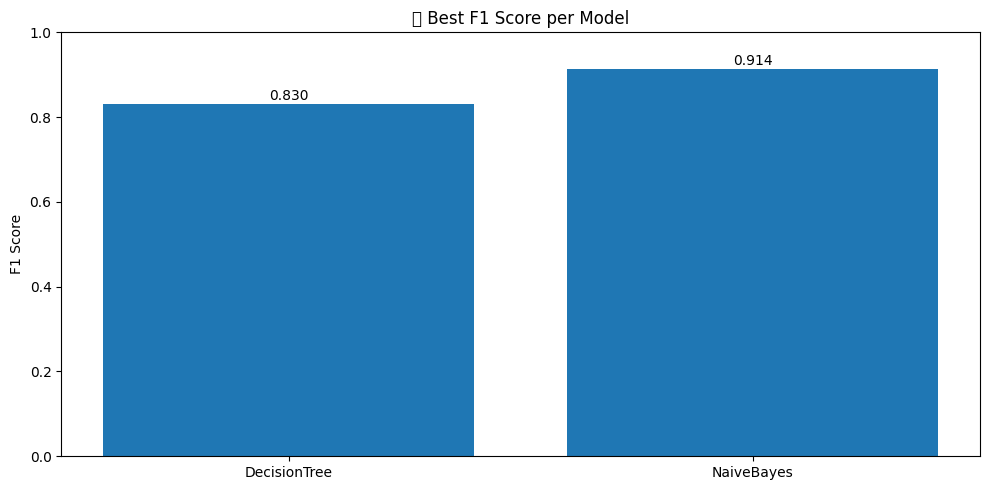

In [9]:
plot_best_per_model("models/results/classical_models_tuned/research_nb_dt_summary.csv")

In [10]:
import seaborn as sns

def plot_vectorizer_model_heatmap(csv_path):
    df = pd.read_csv(csv_path)
    pivot = df.pivot_table(index="Vec", columns="Model", values="F1", aggfunc="max")

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("📊 F1 Score per Model–Vectorizer Combo")
    plt.savefig("models/results/classical_models_tuned/vectorizer_model_f1_heatmap.png")
    plt.show()

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1979247212.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/vectorizer_model_f1_heatmap.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


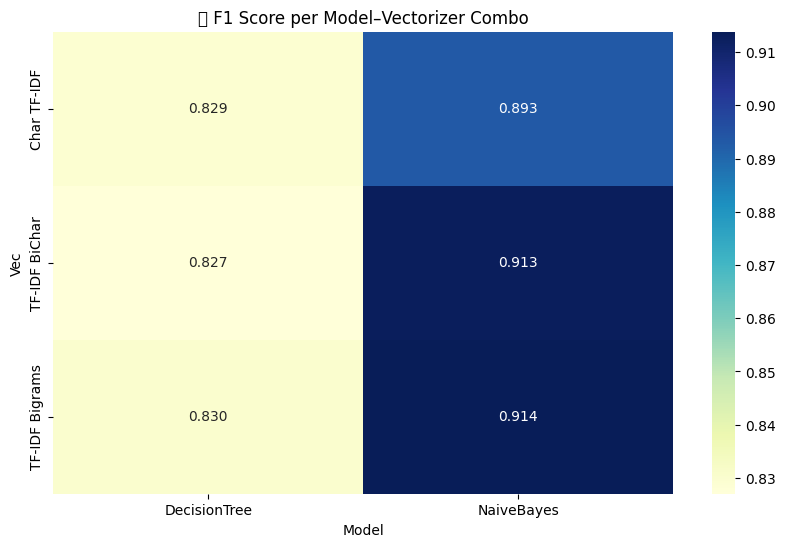

In [11]:
plot_vectorizer_model_heatmap("models/results/classical_models_tuned/research_nb_dt_summary.csv")

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from scipy.sparse import hstack

# 📄 Load summary CSV
summary_df = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")

# 🔍 Get best Naive Bayes config
nb_best = summary_df[summary_df["Model"] == "NaiveBayes"].sort_values(by="F1", ascending=False).iloc[0]
nb_vec = nb_best["Vec"]
nb_alpha = nb_best["alpha"]

# 🔍 Get best Decision Tree config
dt_best = summary_df[summary_df["Model"] == "DecisionTree"].sort_values(by="F1", ascending=False).iloc[0]
dt_vec = dt_best["Vec"]
dt_depth = int(dt_best["Depth"])
dt_split = int(dt_best["Split"])
dt_crit = dt_best["Criterion"]

print(f"🏆 Best NB → {nb_vec}, alpha={nb_alpha}")
print(f"🏆 Best DT → {dt_vec}, depth={dt_depth}, split={dt_split}, criterion={dt_crit}")

# -------------------------------
# 📦 Load Train/Test Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# -------------------------------
# 🔠 Vectorizer Setup
# -------------------------------
def vectorize(name, X_train, X_test):
    if name == "TF-IDF BiChar":
        vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
        vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
        return (
            hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)]),
            hstack([vec1.transform(X_test), vec2.transform(X_test)])
        )
    elif name == "Char TF-IDF":
        vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    elif name == "TF-IDF Bigrams":
        vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    else:
        raise ValueError("Unknown vectorizer")

    return vec.fit_transform(X_train), vec.transform(X_test)

# -------------------------------
# ✅ Train Best Naive Bayes
# -------------------------------
X_train_nb, X_test_nb = vectorize(nb_vec, X_train, X_test)
nb_model = MultinomialNB(alpha=nb_alpha)
nb_model.fit(X_train_nb, y_train)
nb_preds = nb_model.predict(X_test_nb)
nb_probs = nb_model.predict_proba(X_test_nb)[:, 1]

print(f"\n📊 Naive Bayes ({nb_vec})")
print(classification_report(y_test, nb_preds, digits=4))
print(f"F1 Score: {f1_score(y_test, nb_preds):.4f}")
print(f"AUC: {roc_auc_score(y_test, nb_probs):.4f}")

# -------------------------------
# ✅ Train Best Decision Tree
# -------------------------------
X_train_dt, X_test_dt = vectorize(dt_vec, X_train, X_test)
dt_model = DecisionTreeClassifier(
    max_depth=dt_depth,
    min_samples_split=dt_split,
    criterion=dt_crit,
    random_state=42
)
dt_model.fit(X_train_dt, y_train)
dt_preds = dt_model.predict(X_test_dt)
dt_probs = dt_model.predict_proba(X_test_dt)[:, 1]

print(f"\n📊 Decision Tree ({dt_vec})")
print(classification_report(y_test, dt_preds, digits=4))
print(f"F1 Score: {f1_score(y_test, dt_preds):.4f}")
print(f"AUC: {roc_auc_score(y_test, dt_probs):.4f}")

🏆 Best NB → TF-IDF Bigrams, alpha=0.1
🏆 Best DT → TF-IDF Bigrams, depth=50, split=2, criterion=gini

📊 Naive Bayes (TF-IDF Bigrams)
              precision    recall  f1-score   support

           0     0.9271    0.9370    0.9320      3000
           1     0.9200    0.9077    0.9138      2395

    accuracy                         0.9240      5395
   macro avg     0.9236    0.9224    0.9229      5395
weighted avg     0.9240    0.9240    0.9239      5395

F1 Score: 0.9138
AUC: 0.9748

📊 Decision Tree (TF-IDF Bigrams)
              precision    recall  f1-score   support

           0     0.8271    0.9550    0.8864      3000
           1     0.9301    0.7499    0.8303      2395

    accuracy                         0.8639      5395
   macro avg     0.8786    0.8524    0.8584      5395
weighted avg     0.8728    0.8639    0.8615      5395

F1 Score: 0.8303
AUC: 0.8482


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test_vec, y_test, title="Confusion Matrix"):
    y_pred = model.predict(X_test_vec)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    print("📋 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

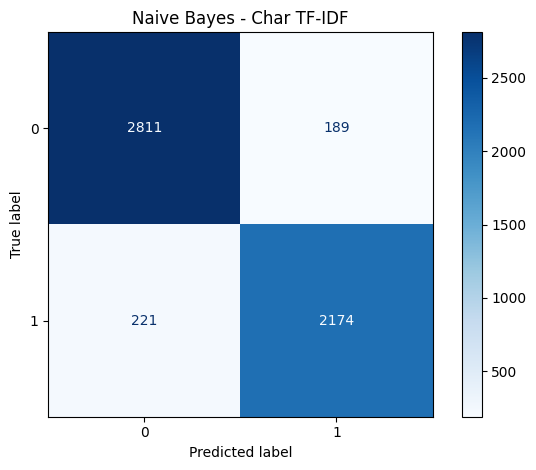

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9271    0.9370    0.9320      3000
           1     0.9200    0.9077    0.9138      2395

    accuracy                         0.9240      5395
   macro avg     0.9236    0.9224    0.9229      5395
weighted avg     0.9240    0.9240    0.9239      5395



In [16]:
plot_confusion_matrix(nb_model, X_test_nb, y_test, title="Naive Bayes - Char TF-IDF")

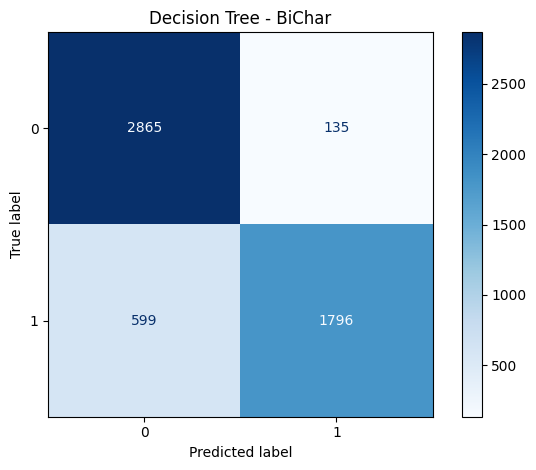

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.8271    0.9550    0.8864      3000
           1     0.9301    0.7499    0.8303      2395

    accuracy                         0.8639      5395
   macro avg     0.8786    0.8524    0.8584      5395
weighted avg     0.8728    0.8639    0.8615      5395



In [17]:
plot_confusion_matrix(dt_model, X_test_dt, y_test, title="Decision Tree - BiChar")

In [18]:
def inspect_errors(model, X_test_vec, y_test, original_texts):
    y_pred = model.predict(X_test_vec)
    mask = y_pred != y_test
    errors = pd.DataFrame({
        "clean_headline": original_texts[mask].values,
        "true_label": y_test[mask].values,
        "predicted": y_pred[mask]
    })
    return errors

In [19]:
def save_errors_to_csv(errors_df, model_name, vec_name):
    os.makedirs("models/error_inspection", exist_ok=True)
    filename = f"models/error_inspection/errors_{model_name}_{vec_name.replace(' ', '_')}.csv"
    errors_df.to_csv(filename, index=False)
    print(f"✅ Saved errors to {filename}")

In [20]:
from collections import Counter
import re

def get_common_words(errors_df, top_n=20):
    all_text = " ".join(errors_df["clean_headline"].tolist()).lower()
    tokens = re.findall(r"\b\w+\b", all_text)
    freq = Counter(tokens).most_common(top_n)
    print("🧾 Most Frequent Words in Misclassifications:")
    for word, count in freq:
        print(f"{word}: {count}")

In [21]:
def separate_fp_fn(errors_df):
    fp = errors_df[(errors_df["true_label"] == 0) & (errors_df["predicted"] == 1)]
    fn = errors_df[(errors_df["true_label"] == 1) & (errors_df["predicted"] == 0)]
    print(f"⚠️ False Positives: {len(fp)} | ❌ False Negatives: {len(fn)}")
    return fp, fn

In [24]:
# Use the correct vectorized test input from training
errors = inspect_errors(nb_model, X_test_nb, y_test, X_test)
save_errors_to_csv(errors, "NaiveBayes", nb_vec)
get_common_words(errors)
fp, fn = separate_fp_fn(errors)

✅ Saved errors to models/error_inspection/errors_NaiveBayes_TF-IDF_Bigrams.csv
🧾 Most Frequent Words in Misclassifications:
india: 21
modi: 15
bjp: 15
woman: 14
say: 13
not: 12
indian: 11
video: 11
pm: 10
time: 10
claim: 9
pakistan: 9
mp: 8
people: 8
photo: 8
delhi: 8
new: 8
attack: 8
water: 8
find: 7
⚠️ False Positives: 189 | ❌ False Negatives: 221


In [25]:
# 🧠 Inspect Errors - Decision Tree
errors_dt = inspect_errors(dt_model, X_test_dt, y_test, X_test)
save_errors_to_csv(errors_dt, "DecisionTree", dt_vec)
get_common_words(errors_dt)
fp_dt, fn_dt = separate_fp_fn(errors_dt)

✅ Saved errors to models/error_inspection/errors_DecisionTree_TF-IDF_Bigrams.csv
🧾 Most Frequent Words in Misclassifications:
india: 37
woman: 26
modi: 25
not: 25
police: 23
congress: 21
pm: 21
say: 20
share: 20
old: 19
video: 19
bjp: 18
government: 18
new: 17
shah: 17
attack: 16
delhi: 16
election: 16
claim: 15
people: 15
⚠️ False Positives: 135 | ❌ False Negatives: 599


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1944653326.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1944653326.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/nb_vs_dt_f1_auc.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


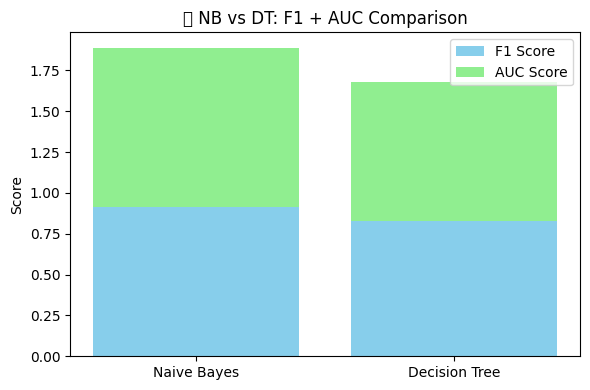


📊 Model Score Table:
Naive Bayes → F1: 0.9138, AUC: 0.9748
Decision Tree → F1: 0.8303, AUC: 0.8482


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load summary
summary = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")

# Get best configs
nb_best = summary[summary["Model"] == "NaiveBayes"].sort_values(by="F1", ascending=False).iloc[0]
dt_best = summary[summary["Model"] == "DecisionTree"].sort_values(by="F1", ascending=False).iloc[0]

# Extract scores
models = ["Naive Bayes", "Decision Tree"]
f1_scores = [nb_best["F1"], dt_best["F1"]]
auc_scores = [nb_best["AUC"], dt_best["AUC"]]

# Plot
plt.figure(figsize=(6, 4))
bar1 = plt.bar(models, f1_scores, color="skyblue", label="F1 Score")
bar2 = plt.bar(models, auc_scores, bottom=f1_scores, color="lightgreen", label="AUC Score")
plt.ylabel("Score")
plt.title("📊 NB vs DT: F1 + AUC Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("models/results/classical_models_tuned/nb_vs_dt_f1_auc.png")
plt.show()

# Print for tabular use
print("\n📊 Model Score Table:")
for i in range(2):
    print(f"{models[i]} → F1: {f1_scores[i]:.4f}, AUC: {auc_scores[i]:.4f}")

In [27]:
import pandas as pd

# Load saved misclassified errors CSV
errors_df = pd.read_csv("models/error_inspection/errors_NaiveBayes_TF-IDF_Bigrams.csv")

# Optional: preview some
errors_df.sample(5)

,clean_headline,true_label,predicted
45,antidrug rally punjab village ward health mini...,0,1
136,ayush min say ayurveda cure prince charle offi...,1,0
174,french footballer paul pogba leave national team,1,0
132,post railway concession senior citizen,1,0
74,mahesh lie love student love,1,0


In [28]:
# Example: add error types manually
manual_tags = {
    12: "satire",
    35: "ambiguous",
    48: "clickbait",
    57: "factual overlap",
    73: "named entity confusion"
}

# Apply tags
for idx, tag in manual_tags.items():
    if idx < len(errors_df):
        errors_df.at[idx, "error_type"] = tag

# Fill others as 'unknown'
errors_df["error_type"] = errors_df["error_type"].fillna("unknown")

In [29]:
errors_df.to_csv("models/error_inspection/errors_NaiveBayes_TF-IDF_Bigrams_annotated.csv", index=False)
print("✅ Annotated error types saved.")

✅ Annotated error types saved.


In [30]:
print("🔍 Error Type Distribution:")
print(errors_df["error_type"].value_counts())

🔍 Error Type Distribution:
error_type
unknown                   405
satire                      1
ambiguous                   1
clickbait                   1
factual overlap             1
named entity confusion      1
Name: count, dtype: int64


In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack

# -------------------------------
# 🔍 Step 1: Load best NB config
# -------------------------------
summary = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")
nb_best = summary[summary["Model"] == "NaiveBayes"].sort_values("F1", ascending=False).iloc[0]
nb_vec = nb_best["Vec"]
nb_alpha = float(nb_best["alpha"])

print(f"🏆 Best NB → Vec: {nb_vec}, Alpha: {nb_alpha}")

# -------------------------------
# 📦 Step 2: Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]

# -------------------------------
# 🔠 Step 3: Vectorize
# -------------------------------
if nb_vec == "TF-IDF BiChar":
    vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
    vocab = list(vec1.get_feature_names_out()) + list(vec2.get_feature_names_out())
elif nb_vec == "Char TF-IDF":
    vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    vocab = vec.get_feature_names_out()
elif nb_vec == "TF-IDF Bigrams":
    vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    vocab = vec.get_feature_names_out()
else:
    raise ValueError("Unsupported vectorizer.")

# -------------------------------
# ✅ Step 4: Train NB
# -------------------------------
nb_model = MultinomialNB(alpha=nb_alpha)
nb_model.fit(X_train_vec, y_train)
log_probs = nb_model.feature_log_prob_  # shape: [n_classes, n_features]

# -------------------------------
# 📊 Step 5: Show + Save Top Words
# -------------------------------
def save_top_words(log_probs, vocab, class_names=["real", "fake"], top_n=15):
    vocab = np.array(vocab)
    rows = []
    for i, name in enumerate(class_names):
        top_idx = np.argsort(log_probs[i])[::-1][:top_n]
        print(f"\n📌 Top {top_n} words for class '{name}':")
        for rank, idx in enumerate(top_idx, 1):
            word = vocab[idx]
            print(f"{rank}. {word}")
            rows.append({"Class": name, "Word": word, "LogProb": log_probs[i][idx], "Rank": rank})
    df = pd.DataFrame(rows)
    os.makedirs("models/interpretability", exist_ok=True)
    df.to_csv("models/interpretability/nb_top_words.csv", index=False)
    print("\n✅ Saved top words to models/interpretability/nb_top_words.csv")

save_top_words(log_probs, vocab, class_names=["real", "fake"], top_n=15)

🏆 Best NB → Vec: TF-IDF Bigrams, Alpha: 0.1

📌 Top 15 words for class 'real':
1. india
2. new
3. delhi
4. say
5. hold
6. man
7. day
8. meet
9. year
10. govt
11. case
12. rs
13. woman
14. city
15. police

📌 Top 15 words for class 'fake':
1. video
2. truth
3. old
4. fake
5. share
6. photo
7. claim
8. news
9. picture
10. know
11. modi
12. bjp
13. go
14. image
15. know truth

✅ Saved top words to models/interpretability/nb_top_words.csv


🏆 Best DT → TF-IDF Bigrams, depth=50, split=2, criterion=gini


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/3046690370.py:68: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/3046690370.py:69: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/dt_feature_importance.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


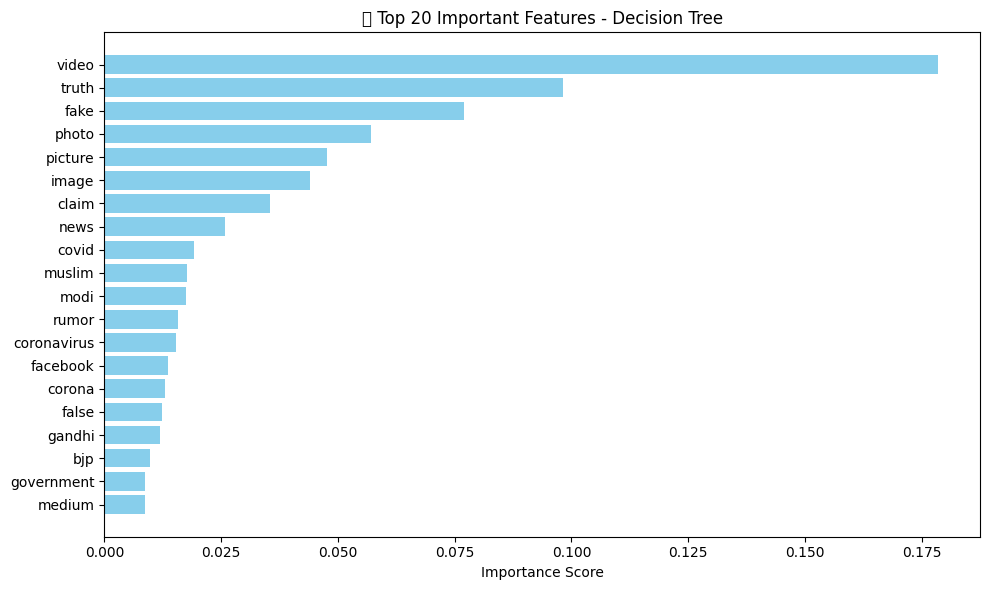

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# -------------------------------
# 🔍 Load Best DT Config
# -------------------------------
summary_df = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")
dt_best = summary_df[summary_df["Model"] == "DecisionTree"].sort_values(by="F1", ascending=False).iloc[0]

vec_name = dt_best["Vec"]
depth = int(dt_best["Depth"])
split = int(dt_best["Split"])
criterion = dt_best["Criterion"]

print(f"🏆 Best DT → {vec_name}, depth={depth}, split={split}, criterion={criterion}")

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]

# -------------------------------
# 🔠 Vectorization
# -------------------------------
if vec_name == "TF-IDF Bigrams":
    vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    feature_names = vec.get_feature_names_out()

elif vec_name == "Char TF-IDF":
    vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    feature_names = vec.get_feature_names_out()

elif vec_name == "TF-IDF BiChar":
    vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
    feature_names = np.concatenate([vec1.get_feature_names_out(), vec2.get_feature_names_out()])

else:
    raise ValueError("Unknown vectorizer")

# -------------------------------
# 🌳 Train DT & Get Importance
# -------------------------------
dt = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, criterion=criterion, random_state=42)
dt.fit(X_train_vec, y_train)

importances = dt.feature_importances_
top_n = 20
indices = np.argsort(importances)[-top_n:]

# -------------------------------
# 📊 Plot Top Features
# -------------------------------
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices], color="skyblue")
plt.yticks(range(top_n), [feature_names[i] for i in indices])
plt.xlabel("Importance Score")
plt.title("🌳 Top 20 Important Features - Decision Tree")
plt.tight_layout()
plt.savefig("models/results/classical_models_tuned/dt_feature_importance.png")
plt.show()

🏆 NB: TF-IDF Bigrams, alpha=0.1
🏆 DT: TF-IDF Bigrams, depth=50, split=2, criterion=gini

📌 NB Top 15 for class 'real':
1. india (-6.08)
2. new (-6.09)
3. delhi (-6.27)
4. say (-6.34)
5. hold (-6.42)
6. man (-6.43)
7. day (-6.45)
8. meet (-6.47)
9. year (-6.50)
10. govt (-6.54)
11. case (-6.61)
12. rs (-6.64)
13. woman (-6.68)
14. city (-6.68)
15. police (-6.74)

📌 NB Top 15 for class 'fake':
1. video (-4.75)
2. truth (-5.14)
3. old (-5.43)
4. fake (-5.46)
5. share (-5.47)
6. photo (-5.55)
7. claim (-5.58)
8. news (-5.84)
9. picture (-5.89)
10. know (-5.92)
11. modi (-5.93)
12. bjp (-5.94)
13. go (-5.97)
14. image (-6.01)
15. know truth (-6.04)
✅ Saved NB top words.


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/2857299892.py:102: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/2857299892.py:103: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.savefig("models/interpretability/dt_feature_importance.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


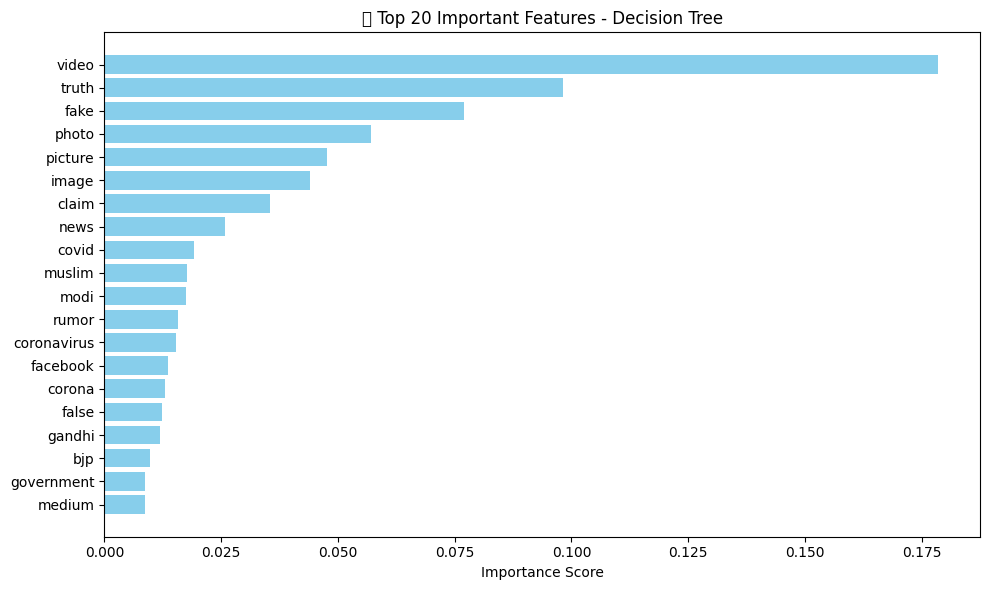

✅ Saved DT top features and plot.


In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import hstack

# -------------------------------
# 📂 Load Best Configs from Summary
# -------------------------------
summary = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")
nb_best = summary[summary["Model"] == "NaiveBayes"].sort_values("F1", ascending=False).iloc[0]
dt_best = summary[summary["Model"] == "DecisionTree"].sort_values("F1", ascending=False).iloc[0]

# NB Config
nb_vec = nb_best["Vec"]
nb_alpha = float(nb_best["alpha"])

# DT Config
dt_vec = dt_best["Vec"]
dt_depth = int(dt_best["Depth"])
dt_split = int(dt_best["Split"])
dt_criterion = dt_best["Criterion"]

print(f"🏆 NB: {nb_vec}, alpha={nb_alpha}")
print(f"🏆 DT: {dt_vec}, depth={dt_depth}, split={dt_split}, criterion={dt_criterion}")

# -------------------------------
# 📦 Load Dataset
# -------------------------------
df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
X = df["clean_headline"].astype(str)
y = df["label_encoded"]

# -------------------------------
# 🔠 Vectorization Utility
# -------------------------------
def vectorize(name, X):
    if name == "TF-IDF Bigrams":
        vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
        X_vec = vec.fit_transform(X)
        vocab = vec.get_feature_names_out()
    elif name == "Char TF-IDF":
        vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
        X_vec = vec.fit_transform(X)
        vocab = vec.get_feature_names_out()
    elif name == "TF-IDF BiChar":
        vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
        vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
        X_vec = hstack([vec1.fit_transform(X), vec2.fit_transform(X)])
        vocab = np.concatenate([vec1.get_feature_names_out(), vec2.get_feature_names_out()])
    else:
        raise ValueError("❌ Unknown vectorizer!")
    return X_vec, vocab

# -------------------------------
# ✅ NB: Train and Save Log-Likelihood Words
# -------------------------------
X_nb, vocab_nb = vectorize(nb_vec, X)
nb_model = MultinomialNB(alpha=nb_alpha)
nb_model.fit(X_nb, y)
log_probs = nb_model.feature_log_prob_

def save_nb_likelihood_words(log_probs, vocab, class_names=["real", "fake"], top_n=15):
    os.makedirs("models/interpretability", exist_ok=True)
    rows = []
    vocab = np.array(vocab)
    for i, cls in enumerate(class_names):
        top_idx = np.argsort(log_probs[i])[::-1][:top_n]
        print(f"\n📌 NB Top {top_n} for class '{cls}':")
        for rank, idx in enumerate(top_idx, 1):
            word = vocab[idx]
            logp = log_probs[i][idx]
            print(f"{rank}. {word} ({logp:.2f})")
            rows.append({"Class": cls, "Word": word, "LogProb": logp, "Rank": rank})
    pd.DataFrame(rows).to_csv("models/interpretability/nb_top_words.csv", index=False)
    print("✅ Saved NB top words.")

save_nb_likelihood_words(log_probs, vocab_nb)

# -------------------------------
# ✅ DT: Train and Save Feature Importances
# -------------------------------
X_dt, vocab_dt = vectorize(dt_vec, X)
dt_model = DecisionTreeClassifier(max_depth=dt_depth, min_samples_split=dt_split, criterion=dt_criterion, random_state=42)
dt_model.fit(X_dt, y)
importances = dt_model.feature_importances_

def save_dt_top_features(importances, vocab, top_n=20):
    indices = np.argsort(importances)[-top_n:]
    top_words = np.array(vocab)[indices]
    top_scores = importances[indices]

    os.makedirs("models/interpretability", exist_ok=True)
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), top_scores, color="skyblue")
    plt.yticks(range(top_n), top_words)
    plt.xlabel("Importance Score")
    plt.title("🌳 Top 20 Important Features - Decision Tree")
    plt.tight_layout()
    plt.savefig("models/interpretability/dt_feature_importance.png")
    plt.show()
    print("✅ Saved DT top features and plot.")

save_dt_top_features(importances, vocab_dt)

In [38]:
import pandas as pd

# Load individual CSVs
nb_df = pd.read_csv("models/interpretability/nb_top_words.csv")
dt_df = pd.read_csv("models/interpretability/dt_top_features.csv")

# Rename columns for clarity before merging
nb_df = nb_df.rename(columns={"Word": "Word_NB", "LogProb": "NB_LogProb", "Rank": "NB_Rank"})
dt_df = dt_df.rename(columns={"Word": "Word_DT", "Importance": "DT_Importance", "Rank": "DT_Rank"})

# -------------------------------
# Merge for Paper-Ready Comparison
# -------------------------------
max_rows = max(len(nb_df), len(dt_df))
nb_df = nb_df.reset_index(drop=True)
dt_df = dt_df.reset_index(drop=True)

# Pad the shorter dataframe
if len(nb_df) < max_rows:
    for col in nb_df.columns:
        nb_df.loc[max_rows-1, col] = None
if len(dt_df) < max_rows:
    for col in dt_df.columns:
        dt_df.loc[max_rows-1, col] = None

# Concatenate side-by-side
comparison_df = pd.concat([nb_df, dt_df], axis=1)

# Save the merged table
comparison_df.to_csv("models/interpretability/nb_vs_dt_feature_comparison.csv", index=False)
print(comparison_df )
print("✅ Saved merged feature comparison to: models/interpretability/nb_vs_dt_feature_comparison.csv")

   Class     Word_NB  NB_LogProb  NB_Rank      Word_DT  DT_Importance  DT_Rank
0   real       india   -6.077627        1       medium       0.008649     20.0
1   real         new   -6.091691        2   government       0.008774     19.0
2   real       delhi   -6.271957        3          bjp       0.009811     18.0
3   real         say   -6.343321        4       gandhi       0.011968     17.0
4   real        hold   -6.415217        5        false       0.012342     16.0
5   real         man   -6.433341        6       corona       0.012989     15.0
6   real         day   -6.454139        7     facebook       0.013637     14.0
7   real        meet   -6.468701        8  coronavirus       0.015409     13.0
8   real        year   -6.503937        9        rumor       0.015826     12.0
9   real        govt   -6.535498       10         modi       0.017423     11.0
10  real        case   -6.611151       11       muslim       0.017649     10.0
11  real          rs   -6.643953       12        cov

✅ Saved merged feature comparison to models/interpretability/nb_vs_dt_feature_comparison.csv
🔍 NB-only: 20 | DT-only: 10 | Shared: 10


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/3757659508.py:47: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/3757659508.py:48: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("models/interpretability/nb_vs_dt_venn.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


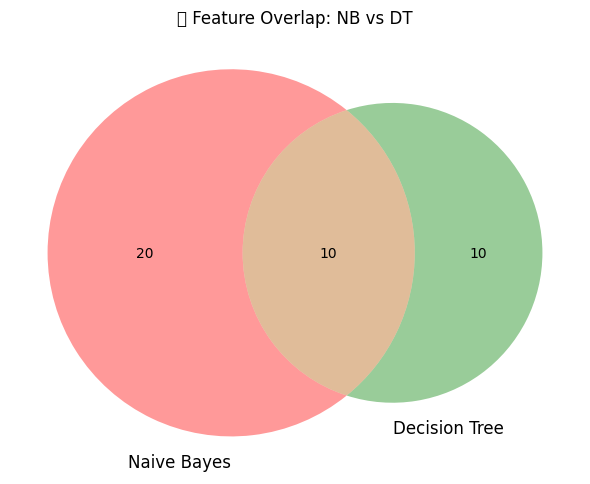

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/3757659508.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/3757659508.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/interpretability/nb_vs_dt_overlap_bar.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


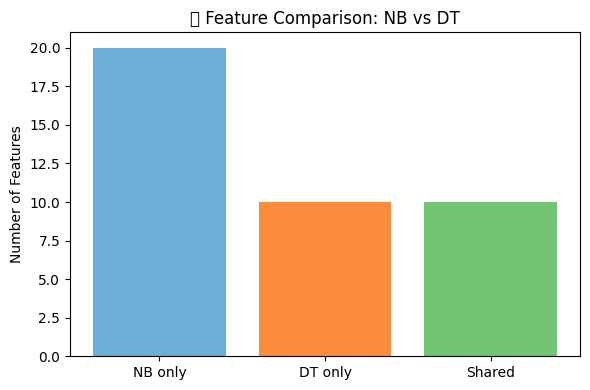

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import os

# -------------------------------
# 📥 Load Top Features
# -------------------------------
nb_path = "models/interpretability/nb_top_words.csv"
dt_path = "models/interpretability/dt_top_features.csv"

nb_df = pd.read_csv(nb_path)
dt_df = pd.read_csv(dt_path)

nb_words = set(nb_df["Word"])
dt_words = set(dt_df["Word"])

# -------------------------------
# 🔁 Merge for Comparison Table
# -------------------------------
comparison_df = pd.merge(
    nb_df, dt_df,
    left_on="Word", right_on="Word",
    how="outer",
    suffixes=("_NB", "_DT")
)

os.makedirs("models/interpretability", exist_ok=True)
comparison_df.to_csv("models/interpretability/nb_vs_dt_feature_comparison.csv", index=False)
print("✅ Saved merged feature comparison to models/interpretability/nb_vs_dt_feature_comparison.csv")

# -------------------------------
# 🔍 Overlap Analysis
# -------------------------------
nb_only = nb_words - dt_words
dt_only = dt_words - nb_words
shared = nb_words & dt_words

print(f"🔍 NB-only: {len(nb_only)} | DT-only: {len(dt_only)} | Shared: {len(shared)}")

# -------------------------------
# 📊 Venn Diagram
# -------------------------------
plt.figure(figsize=(6, 6))
venn2([nb_words, dt_words], set_labels=("Naive Bayes", "Decision Tree"))
plt.title("🔍 Feature Overlap: NB vs DT")
plt.tight_layout()
plt.savefig("models/interpretability/nb_vs_dt_venn.png")
plt.show()

# -------------------------------
# 📊 Bar Chart: Overlap Stats
# -------------------------------
plt.figure(figsize=(6, 4))
plt.bar(["NB only", "DT only", "Shared"], [len(nb_only), len(dt_only), len(shared)], color=["#6BAED6", "#FD8D3C", "#74C476"])
plt.ylabel("Number of Features")
plt.title("📊 Feature Comparison: NB vs DT")
plt.tight_layout()
plt.savefig("models/interpretability/nb_vs_dt_overlap_bar.png")
plt.show()

In [43]:
import os
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

# -------------------------------
# 🔧 Setup
# -------------------------------
os.makedirs("models/interpretability", exist_ok=True)
summary = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")
nb_best = summary[summary["Model"] == "NaiveBayes"].sort_values("F1", ascending=False).iloc[0]
vec_type = nb_best["Vec"]
nb_alpha = float(nb_best["alpha"])

print(f"🏆 Best NB → {vec_type}, alpha={nb_alpha}")

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])

X_train = train_df["clean_headline"].astype(str).reset_index(drop=True)
y_train = train_df["label_encoded"].reset_index(drop=True)
X_test = test_df["clean_headline"].astype(str).reset_index(drop=True)
y_test = test_df["label_encoded"].reset_index(drop=True)

# -------------------------------
# 🔠 Define vectorizer
# -------------------------------
if vec_type == "TF-IDF Bigrams":
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
elif vec_type == "Char TF-IDF":
    vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
elif vec_type == "TF-IDF BiChar":
    vectorizer = FeatureUnion([
        ('word', TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
        ('char', TfidfVectorizer(analyzer='char', ngram_range=(2, 5), min_df=2))
    ])
else:
    raise ValueError("Unsupported vectorizer type.")

# -------------------------------
# ✅ Train pipeline
# -------------------------------
pipeline = make_pipeline(vectorizer, MultinomialNB(alpha=nb_alpha))
pipeline.fit(X_train, y_train)

# -------------------------------
# 🧠 LIME Explanation
# -------------------------------
class_names = ["real", "fake"]
explainer = LimeTextExplainer(class_names=class_names)

# 📌 Choose a sample
sample_idx = 10
sample_text = X_test.iloc[sample_idx]

print(f"\n🧾 Headline: {sample_text}")
print(f"🔮 True Label: {class_names[y_test.iloc[sample_idx]]}")

# ✅ Explain and Save
exp = explainer.explain_instance(sample_text, pipeline.predict_proba, num_features=10)

# Don't use show_in_notebook (causes error in some environments)
# exp.show_in_notebook(text=sample_text)

exp.save_to_file(f"models/interpretability/lime_nb_sample_{sample_idx}.html")
print(f"✅ Saved LIME HTML explanation → lime_nb_sample_{sample_idx}.html")

🏆 Best NB → TF-IDF Bigrams, alpha=0.1

🧾 Headline: catch cctv suv driver run security guard honk dispute
🔮 True Label: real
✅ Saved LIME HTML explanation → lime_nb_sample_10.html


In [44]:
import os
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# -------------------------------
# 🔧 Config
# -------------------------------
summary = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")
nb_best = summary[summary["Model"] == "NaiveBayes"].sort_values("F1", ascending=False).iloc[0]
vec_type = nb_best["Vec"]
nb_alpha = float(nb_best["alpha"])
os.makedirs("models/interpretability/lime_fp_fn", exist_ok=True)

# -------------------------------
# 📦 Load FP/FN Errors
# -------------------------------
errors = pd.read_csv("models/error_inspection/errors_NaiveBayes_TF-IDF_Bigrams.csv")  # adjust path if needed
fp = errors[(errors["true_label"] == 0) & (errors["predicted"] == 1)]
fn = errors[(errors["true_label"] == 1) & (errors["predicted"] == 0)]

print(f"⚠️ False Positives: {len(fp)}, ❌ False Negatives: {len(fn)}")

# -------------------------------
# 🧠 Prepare Model Pipeline
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = train_df["clean_headline"].astype(str).reset_index(drop=True)
y_train = train_df["label_encoded"].reset_index(drop=True)

if vec_type == "TF-IDF Bigrams":
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
elif vec_type == "Char TF-IDF":
    vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
elif vec_type == "TF-IDF BiChar":
    from sklearn.pipeline import FeatureUnion
    vectorizer = FeatureUnion([
        ('word', TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
        ('char', TfidfVectorizer(analyzer='char', ngram_range=(2, 5), min_df=2))
    ])
else:
    raise ValueError("Unsupported vectorizer.")

pipeline = make_pipeline(vectorizer, MultinomialNB(alpha=nb_alpha))
pipeline.fit(X_train, y_train)

# -------------------------------
# 🧪 Run LIME on FP and FN samples
# -------------------------------
explainer = LimeTextExplainer(class_names=["real", "fake"])

def run_lime_on_errors(subset, name):
    for i in range(min(5, len(subset))):  # Pick top 5 FP/FN
        row = subset.iloc[i]
        text = row["clean_headline"]
        exp = explainer.explain_instance(text, pipeline.predict_proba, num_features=10)
        exp.save_to_file(f"models/interpretability/lime_fp_fn/lime_{name}_{i}.html")
        print(f"✅ Saved LIME explanation for {name} sample {i}: {text[:60]}...")

run_lime_on_errors(fp, "fp")
run_lime_on_errors(fn, "fn")

⚠️ False Positives: 189, ❌ False Negatives: 221
✅ Saved LIME explanation for fp sample 0: candidate pamphlet find arm dealer...
✅ Saved LIME explanation for fp sample 1: mamata banerjee mp say unable work...
✅ Saved LIME explanation for fp sample 2: bsf incite flareup murshidabad west bengal cm mamata banerje...
✅ Saved LIME explanation for fp sample 3: group people force entry temple madhya pradesh thrash priest...
✅ Saved LIME explanation for fp sample 4: aicc back state congress tick sibal...
✅ Saved LIME explanation for fn sample 0: sneak peek global factory phishe website impersonate finance...
✅ Saved LIME explanation for fn sample 1: yes pm modi mistake spell word strength china...
✅ Saved LIME explanation for fn sample 2: momo challenge hoax edit peppa pigmomo youtube...
✅ Saved LIME explanation for fn sample 3: person photo get liver transplant give chase...
✅ Saved LIME explanation for fn sample 4: uptet aspirant sleep open cold night...


In [46]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load test data
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])
X_test = test_df["clean_headline"].astype(str)

# Load training data to fit vectorizer
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]

# Use best NB config from summary
summary = pd.read_csv("models/results/classical_models_tuned/research_nb_dt_summary.csv")
nb_best = summary[summary["Model"] == "NaiveBayes"].sort_values(by="F1", ascending=False).iloc[0]
vec_type = nb_best["Vec"]
nb_alpha = float(nb_best["alpha"])

# Vectorize
if vec_type == "TF-IDF Bigrams":
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
elif vec_type == "Char TF-IDF":
    vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
elif vec_type == "TF-IDF BiChar":
    from scipy.sparse import hstack
    vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
    X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
else:
    raise ValueError("Unsupported vectorizer")

if vec_type != "TF-IDF BiChar":
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

# Train and predict
nb = MultinomialNB(alpha=nb_alpha)
nb.fit(X_train_vec, y_train)
preds = nb.predict(X_test_vec)

# Save
pd.DataFrame({"predicted": preds}).to_csv("models/results/classical_models_tuned/nb_predictions.csv", index=False)
print("✅ Saved predictions to nb_predictions.csv")

✅ Saved predictions to nb_predictions.csv


In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# -------------------------------
# 📦 Load Data with Category Info
# -------------------------------
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded", "category"])
X_test = test_df["clean_headline"].astype(str)
y_true = test_df["label_encoded"]
categories = test_df["category"]

# -------------------------------
# 🔍 Load Predictions (re-use NB pipeline)
# -------------------------------
# Assume 'pipeline' (vectorizer + MultinomialNB) is already fitted from previous steps
y_pred = pipeline.predict(X_test)

# -------------------------------
# 📊 Compute Per-Category Metrics
# -------------------------------
results = []

for cat in sorted(categories.unique()):
    mask = categories == cat
    y_cat_true = y_true[mask]
    y_cat_pred = y_pred[mask]

    f1 = f1_score(y_cat_true, y_cat_pred)
    prec = precision_score(y_cat_true, y_cat_pred)
    rec = recall_score(y_cat_true, y_cat_pred)

    results.append({
        "Category": cat,
        "Samples": len(y_cat_true),
        "F1": round(f1, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4)
    })

df_category_metrics = pd.DataFrame(results)
df_category_metrics = df_category_metrics.sort_values("F1", ascending=False)

# -------------------------------
# 💾 Save the Results
# -------------------------------
output_path = "models/results/classical_models_tuned/per_category_metrics.csv"
df_category_metrics.to_csv(output_path, index=False)
print("✅ Per-category metrics saved to:", output_path)

# 🔍 Optional Preview
print(df_category_metrics.to_string(index=False))

✅ Per-category metrics saved to: models/results/classical_models_tuned/per_category_metrics.csv
      Category  Samples     F1  Precision  Recall
      politics      662 0.9366     0.9366  0.9366
 entertainment      521 0.9356     0.9375  0.9336
        health      320 0.9351     0.9402  0.9301
    technology       51 0.9333     1.0000  0.8750
         crime      751 0.9332     0.9458  0.9208
 social issues      334 0.9292     0.9152  0.9437
      religion      407 0.9270     0.9144  0.9400
      business      141 0.9231     0.9545  0.8936
       weather      146 0.8909     0.9074  0.8750
 international      582 0.8861     0.8974  0.8750
     education      171 0.8800     0.9167  0.8462
        sports      923 0.8591     0.8727  0.8458
infrastructure      201 0.8333     0.8654  0.8036
       science       76 0.8163     0.8333  0.8000
   environment      109 0.7727     0.8095  0.7391


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1243565642.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1243565642.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/per_category_metrics_barplot.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


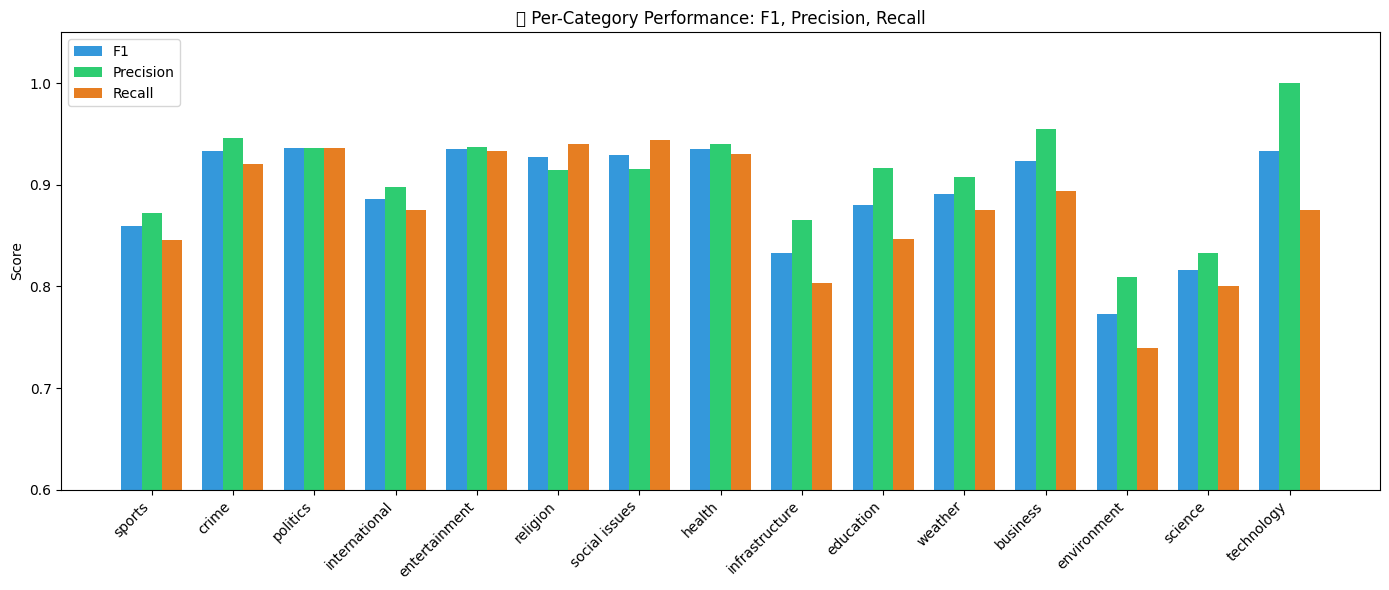

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics
df = pd.read_csv("models/results/classical_models_tuned/per_category_metrics.csv")

# Sort by sample size (optional)
df = df.sort_values("Samples", ascending=False)

# Plot
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(df))

plt.bar(x, df["F1"], width=bar_width, label="F1", color="#3498db")
plt.bar([i + bar_width for i in x], df["Precision"], width=bar_width, label="Precision", color="#2ecc71")
plt.bar([i + 2 * bar_width for i in x], df["Recall"], width=bar_width, label="Recall", color="#e67e22")

plt.xticks([i + bar_width for i in x], df["Category"], rotation=45, ha='right')
plt.ylabel("Score")
plt.ylim(0.6, 1.05)
plt.title("📊 Per-Category Performance: F1, Precision, Recall")
plt.legend()
plt.tight_layout()
plt.savefig("models/results/classical_models_tuned/per_category_metrics_barplot.png")
plt.show()

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1392811363.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1392811363.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/per_category_heatmap.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


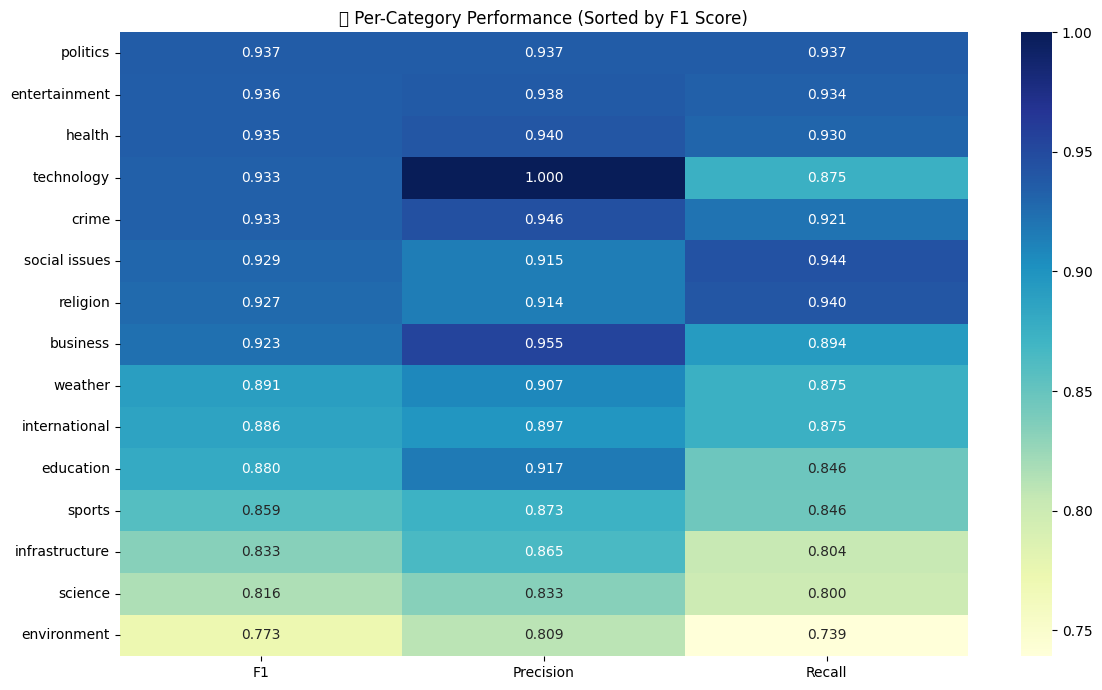

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1392811363.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_22468/1392811363.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/per_category_f1_barplot.png")


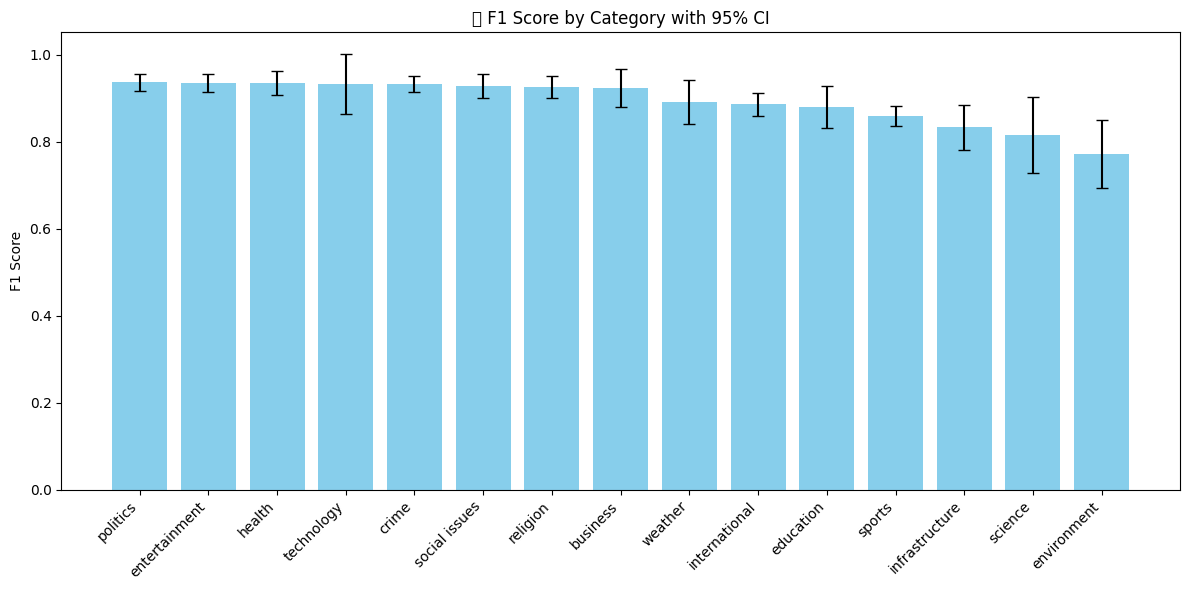

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------
# 📄 Load Per-Category Metrics
# -------------------------------
df = pd.read_csv("models/results/classical_models_tuned/per_category_metrics.csv")

# -------------------------------
# 🧮 Approximate 95% CI (Standard Error)
# -------------------------------
# This assumes a binomial distribution for confidence intervals
def compute_se(p, n):
    return 1.96 * np.sqrt(p * (1 - p) / n)

df["F1_SE"] = compute_se(df["F1"], df["Samples"])
df["Precision_SE"] = compute_se(df["Precision"], df["Samples"])
df["Recall_SE"] = compute_se(df["Recall"], df["Samples"])

# -------------------------------
# 🔥 Heatmap (F1 Sorted)
# -------------------------------
df_sorted = df.sort_values("F1", ascending=False)

plt.figure(figsize=(12, 7))
sns.heatmap(
    df_sorted[["F1", "Precision", "Recall"]],
    annot=True,
    cmap="YlGnBu",
    fmt=".3f",
    yticklabels=df_sorted["Category"]
)
plt.title("📊 Per-Category Performance (Sorted by F1 Score)")
plt.tight_layout()
plt.savefig("models/results/classical_models_tuned/per_category_heatmap.png")
plt.show()

# -------------------------------
# 📉 Bar Plot with Error Bars
# -------------------------------
plt.figure(figsize=(12, 6))
plt.bar(df_sorted["Category"], df_sorted["F1"], yerr=df_sorted["F1_SE"], capsize=4, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("📊 F1 Score by Category with 95% CI")
plt.tight_layout()
plt.savefig("models/results/classical_models_tuned/per_category_f1_barplot.png")
plt.show()

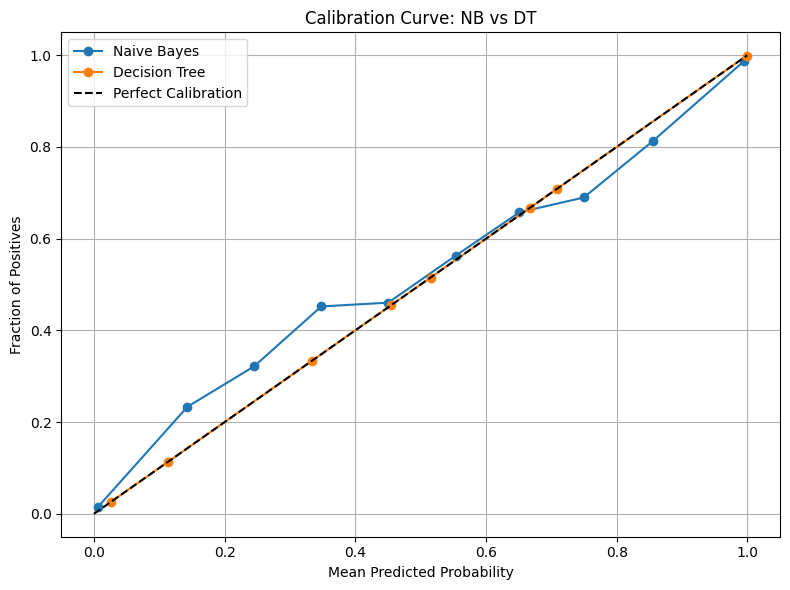

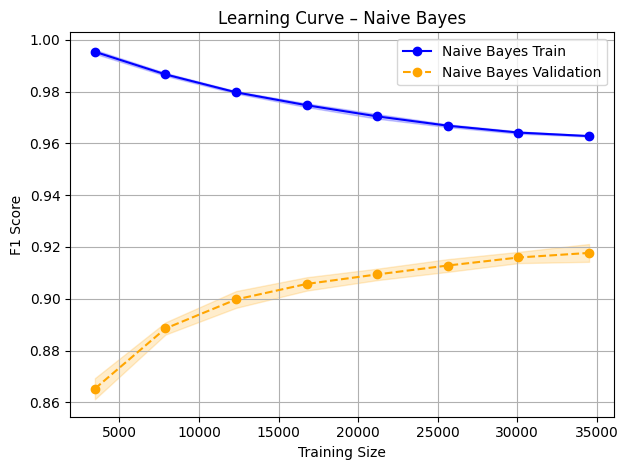

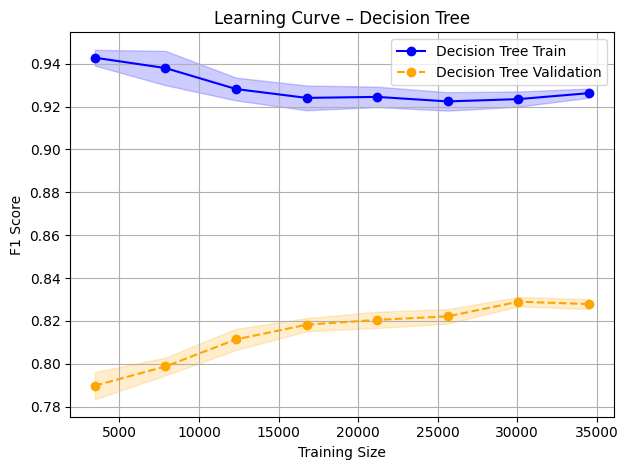

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.calibration import calibration_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# -------------------------------
# 📦 Load Your Data
# -------------------------------
df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X = df["clean_headline"].astype(str).reset_index(drop=True)
y = df["label_encoded"].astype(int).reset_index(drop=True)

# -------------------------------
# 🔠 Vectorize: Word + Char TF-IDF
# -------------------------------
vec_word = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec_char = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_vec = hstack([vec_word.fit_transform(X), vec_char.fit_transform(X)])

# -------------------------------
# 📈 Learning Curve Function
# -------------------------------
def plot_learning_curve(X_vec, y, estimator, name="Model"):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_vec, y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        train_sizes=np.linspace(0.1, 1.0, 8),
        scoring="f1", n_jobs=-1
    )
    train_mean, val_mean = train_scores.mean(axis=1), val_scores.mean(axis=1)
    train_std, val_std = train_scores.std(axis=1), val_scores.std(axis=1)

    plt.plot(train_sizes, train_mean, "o-", label=f"{name} Train", color="blue")
    plt.plot(train_sizes, val_mean, "o--", label=f"{name} Validation", color="orange")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve – {name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------
# 📊 Calibration Curve Function
# -------------------------------
def plot_calibration_curve(X_vec, y, nb_alpha=0.1):
    nb = MultinomialNB(alpha=nb_alpha)
    dt = DecisionTreeClassifier(max_depth=50, min_samples_split=2, criterion="gini", random_state=42)

    prob_nb = nb.fit(X_vec, y).predict_proba(X_vec)[:, 1]
    prob_dt = dt.fit(X_vec, y).predict_proba(X_vec)[:, 1]

    frac_pos_nb, mean_pred_nb = calibration_curve(y, prob_nb, n_bins=10)
    frac_pos_dt, mean_pred_dt = calibration_curve(y, prob_dt, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(mean_pred_nb, frac_pos_nb, "o-", label="Naive Bayes")
    plt.plot(mean_pred_dt, frac_pos_dt, "o-", label="Decision Tree")
    plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve: NB vs DT")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 🔄 Run Everything
# -------------------------------
plot_calibration_curve(X_vec, y)
plot_learning_curve(X_vec, y, MultinomialNB(alpha=0.1), name="Naive Bayes")
plot_learning_curve(X_vec, y, DecisionTreeClassifier(max_depth=50, min_samples_split=2), name="Decision Tree")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1998/3868771215.py:63: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1998/3868771215.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/results/classical_models_tuned/nb_dt_calibration_brier.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


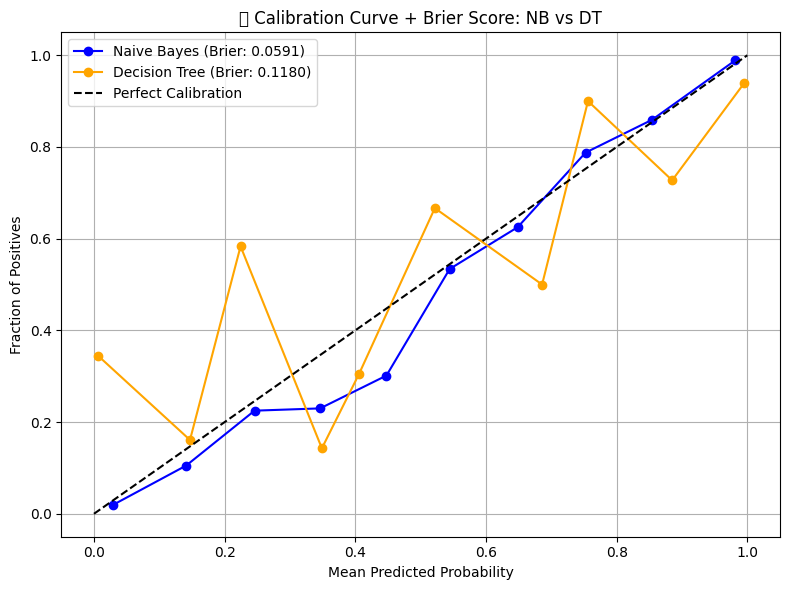

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# -------------------------------
# 📦 Load test data
# -------------------------------
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_test = test_df["clean_headline"].astype(str).reset_index(drop=True)
y_test = test_df["label_encoded"].astype(int).reset_index(drop=True)

# 📦 Load training data for vectorizer
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = train_df["clean_headline"].astype(str).reset_index(drop=True)
y_train = train_df["label_encoded"].astype(int).reset_index(drop=True)

# -------------------------------
# 🔠 TF-IDF Bigrams Vectorization
# -------------------------------
vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

# -------------------------------
# 🧠 Train NB and DT
# -------------------------------
nb_model = MultinomialNB(alpha=0.1)
dt_model = DecisionTreeClassifier(max_depth=50, min_samples_split=2, criterion="gini", random_state=42)
nb_model.fit(X_train_vec, y_train)
dt_model.fit(X_train_vec, y_train)

# -------------------------------
# 📈 Calibration + Brier
# -------------------------------
nb_probs = nb_model.predict_proba(X_test_vec)[:, 1]
dt_probs = dt_model.predict_proba(X_test_vec)[:, 1]

# Calibration curves
nb_frac, nb_mean = calibration_curve(y_test, nb_probs, n_bins=10, strategy="uniform")
dt_frac, dt_mean = calibration_curve(y_test, dt_probs, n_bins=10, strategy="uniform")

# Brier scores
nb_brier = brier_score_loss(y_test, nb_probs)
dt_brier = brier_score_loss(y_test, dt_probs)

# -------------------------------
# 📊 Plot
# -------------------------------
plt.figure(figsize=(8, 6))
plt.plot(nb_mean, nb_frac, "o-", label=f"Naive Bayes (Brier: {nb_brier:.4f})", color="blue")
plt.plot(dt_mean, dt_frac, "o-", label=f"Decision Tree (Brier: {dt_brier:.4f})", color="orange")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("📊 Calibration Curve + Brier Score: NB vs DT")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.savefig("models/results/classical_models_tuned/nb_dt_calibration_brier.png")
plt.show()